In [1]:
# https://theailearner.com/2019/05/29/creating-a-crnn-model-to-recognize-text-in-an-image-part-2
# https://keras.io/examples/vision/handwriting_recognition
# https://github.com/pbcquoc/crnn
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')
APPROACH_NAME = 'SkipConnection'

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Data input pipeline

In [3]:
DATASET_DIR = r'../../Dataset/IHR-NomDB'
LABELS_PATH = r'../../Dataset/IHR-NomDB/labels.txt'
FONT_PATH = r'../../Dataset/NomNaTong-Regular.ttf'

## Load and remove records with rare characters 

In [4]:
from loader import DataImporter
dataset = DataImporter(DATASET_DIR, LABELS_PATH, min_length=1).remove_rare_chars(1)
print(dataset)

Samples count (not include Latin letters, numbers, punctuations):
- Number of images found: 101533
- Number of labels found: 101533
- Number of unique characters: 13168
- Characters present: {'之': 8193, '以': 4931, '月': 4007, '人': 3927, '十': 3611, '年': 3381, '不': 3263, '帝': 2955, '二': 2722, '大': 2641, '有': 2634, '日': 2561, '為': 2548, '其': 2537, '公': 2476, '兵': 2469, '等': 2404, '固': 2381, '於': 2311, '如': 2252, '國': 2194, '時': 2171, '官': 2160, '太': 2153, '爲': 2142, '子': 2140, '一': 2136, '天': 2077, '王': 2061, '軍': 2052, '而': 2019, '三': 1981, '事': 1955, '吏': 1942, '明': 1910, '朱': 1880, '使': 1825, '阮': 1818, '至': 1808, '曰': 1791, '及': 1646, '者': 1638, '文': 1631, '㐌': 1617, '安': 1612, '臣': 1601, '所': 1600, '行': 1569, '埃': 1563, '黎': 1511, '麻': 1494, '上': 1485, '皇': 1469, '也': 1469, '士': 1462, '命': 1444, '民': 1424, '是': 1418, '中': 1409, '自': 1407, '𢚸': 1387, '四': 1354, '五': 1346, '生': 1333, '道': 1331, '爫': 1319, '下': 1293, '郡': 1249, '元': 1243, '山': 1214, '渃': 1201, '𠊛': 1192, '宗': 1174, '莫': 

## Data constants and input pipeline

In [5]:
from loader import DataHandler
HEIGHT, WIDTH = 432, 48
PADDING_CHAR = '[PAD]' 
data_handler = DataHandler(dataset, img_size=(HEIGHT, WIDTH), padding_char=PADDING_CHAR)

In [6]:
MAX_LENGTH = data_handler.max_length
PADDING_TOKEN = data_handler.padding_token
VOCAB_SIZE = data_handler.char2num.vocab_size()
BATCH_SIZE = 32

## Visualize the data

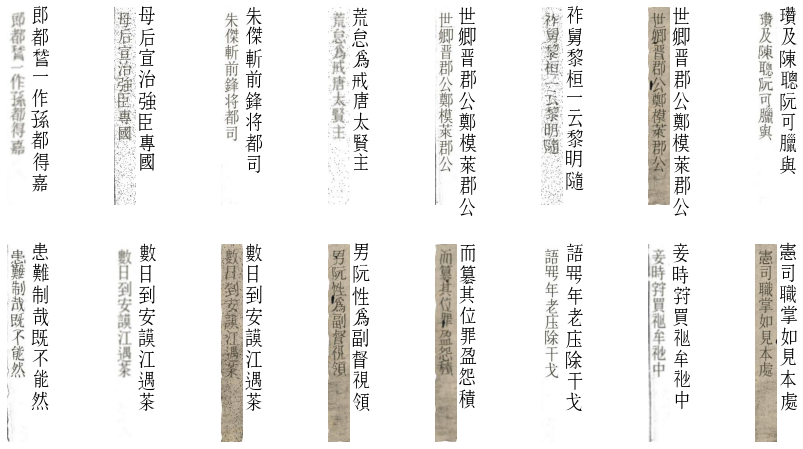

In [7]:
from visualizer import visualize_images_labels
visualize_images_labels(
    dataset.img_paths, 
    dataset.labels, 
    figsize = (15, 8),
    font_path = FONT_PATH, 
    text_x = WIDTH + 3
)

# Define the model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Bidirectional, GRU, Average
from layers import custom_cnn, get_imagenet_model, reshape_for_rnn

In [9]:
def build_crnn(imagenet_model=None, imagenet_output_layer=None, name='CRNN'):
    # CNN layers
    if imagenet_model: # Use Imagenet model as CNN layers
        image_input = imagenet_model.input
        imagenet_model.layers[0]._name = 'image'
        x = imagenet_model.get_layer(imagenet_output_layer).output
    else: 
        image_input = Input(shape=(HEIGHT, WIDTH, 3), dtype='float32', name='image')
        conv_blocks_config = {
            'block1': {'num_conv': 1, 'filters':   64, 'pool_size': (2, 2)}, 
            'block2': {'num_conv': 1, 'filters':  128, 'pool_size': (2, 2)}, 
            'block3': {'num_conv': 2, 'filters':  256, 'pool_size': (2, 2)}, 
            'block4': {'num_conv': 2, 'filters':  512, 'pool_size': (2, 2)}, 
            
            # Last 2 Conv blocks with 2x2 kernel but without padding and pooling layer
            'block5': {'num_conv': 1, 'filters':  512, 'pool_size': None}, 
            'block6': {'num_conv': 1, 'filters': 1024, 'pool_size': None}, 
        }
        x = custom_cnn(conv_blocks_config, image_input)
        
    # Reshape accordingly before passing output to RNN
    feature_maps = reshape_for_rnn(x, dim_to_keep=1)
    
    # RNN layers
    bigru1, forward_state, backward_state = Bidirectional(GRU(
        units = 512, 
        return_sequences = True,
        return_state = True
    ), name = 'bigru1')(feature_maps)

    bigru2 = Bidirectional(GRU(
        units = 512, 
        return_sequences = True,
    ), name = 'bigru2')(bigru1, initial_state=[forward_state, backward_state])
    
    # Skip connection
    x = Average(name='skip_connection')([feature_maps, bigru2])
    
    # Output layer
    y_pred = Dense(
        units = VOCAB_SIZE + 1, # + 1 blank character for CTC loss
        activation = 'softmax', 
        name = 'rnn_output'
    )(x)
    return Model(inputs=image_input, outputs=y_pred, name=name)

In [10]:
imagenet_model, imagenet_output_layer = None, None
# # Pick a model from https://keras.io/api/applications
# imagenet_model = get_imagenet_model('VGG16', (HEIGHT, WIDTH, 1))
# imagenet_output_layer = 'block4_pool'
# imagenet_model.summary(line_length=100)

In [11]:
model = build_crnn(imagenet_model, imagenet_output_layer)
model.summary(line_length=110)

Model: "CRNN"
______________________________________________________________________________________________________________
 Layer (type)                       Output Shape            Param #      Connected to                         
 image (InputLayer)                 [(None, 432, 48, 3)]    0            []                                   
                                                                                                              
 block1_conv1 (Conv2D)              (None, 432, 48, 64)     1792         ['image[0][0]']                      
                                                                                                              
 block1_bn1 (BatchNormalization)    (None, 432, 48, 64)     256          ['block1_conv1[0][0]']               
                                                                                                              
 block1_activation1 (LeakyReLU)     (None, 432, 48, 64)     0            ['block1_bn1[0][0]']     

 rnn_output (Dense)                 (None, 25, 13171)       13500275     ['skip_connection[0][0]']            
                                                                                                              
Total params: 30,610,931
Trainable params: 30,604,403
Non-trainable params: 6,528
______________________________________________________________________________________________________________


# Training

In [12]:
import random
train_idxs = list(range(int(dataset.size * 0.8)))
valid_idxs = list(range(train_idxs[-1] + 1, dataset.size))

random.seed(2022)
random.shuffle(train_idxs)
random.shuffle(valid_idxs)

In [13]:
train_tf_dataset = data_handler.prepare_tf_dataset(train_idxs, BATCH_SIZE)
valid_tf_dataset = data_handler.prepare_tf_dataset(valid_idxs, BATCH_SIZE)
print('Number of training samples:', len(train_idxs))
print('Number of validate samples:', len(valid_idxs))

Number of training samples: 81226
Number of validate samples: 20307


## Train the IHR-NomDB dataset

In [14]:
from losses import CTCLoss
from metrics import SequenceAccuracy, CharacterAccuracy, LevenshteinDistance
from callbacks import EarlyStoppingWithStuck
from tensorflow.keras.optimizers import Adadelta

# Adadelta tends to benefit from higher initial learning rate values compared to
# other optimizers. Here use 1.0 to match the exact form in the original paper
LEARNING_RATE = 1.0
EPOCHS = 100

In [15]:
model.compile(
    optimizer = Adadelta(LEARNING_RATE), 
    loss = CTCLoss(PADDING_TOKEN), 
    metrics = [
        SequenceAccuracy(PADDING_TOKEN, use_ctc_decode=True),
        CharacterAccuracy(PADDING_TOKEN, use_ctc_decode=True),
        LevenshteinDistance(PADDING_TOKEN, use_ctc_decode=True, normalize=True)
    ]
)
early_stopping_callback = EarlyStoppingWithStuck(patience=5)

In [16]:
%%time
history = model.fit(
    train_tf_dataset,
    validation_data = valid_tf_dataset,
    epochs = EPOCHS,
    callbacks = [early_stopping_callback],
    verbose = 1
).history

Epoch 1/100
2539/2539 [==============================] - 398s 154ms/step - loss: 11.4257 - seq_acc: 0.4201 - char_acc: 0.7599 - levenshtein_distance: 0.2362 - val_loss: 3.9605 - val_seq_acc: 0.6868 - val_char_acc: 0.9469 - val_levenshtein_distance: 0.0451
Epoch 2/100
2539/2539 [==============================] - 386s 152ms/step - loss: 2.1956 - seq_acc: 0.7620 - char_acc: 0.9514 - levenshtein_distance: 0.0506 - val_loss: 1.5300 - val_seq_acc: 0.8182 - val_char_acc: 0.9732 - val_levenshtein_distance: 0.0241
Epoch 3/100
2539/2539 [==============================] - 395s 155ms/step - loss: 1.2367 - seq_acc: 0.8560 - char_acc: 0.9722 - levenshtein_distance: 0.0298 - val_loss: 1.4266 - val_seq_acc: 0.8438 - val_char_acc: 0.9771 - val_levenshtein_distance: 0.0202
Epoch 4/100
2539/2539 [==============================] - 386s 152ms/step - loss: 0.7925 - seq_acc: 0.9070 - char_acc: 0.9825 - levenshtein_distance: 0.0193 - val_loss: 2.5864 - val_seq_acc: 0.8315 - val_char_acc: 0.9826 - val_levensht

## Save the training results

In [17]:
best_epoch = early_stopping_callback.best_epoch
print(f'- Loss on validation\t: {history["val_loss"][best_epoch]}')
print(f'- Sequence accuracy\t: {history["val_seq_acc"][best_epoch]}')
print(f'- Character accuracy\t: {history["val_char_acc"][best_epoch]}')
print(f'- Levenshtein distance\t: {history["val_levenshtein_distance"][best_epoch]}')

- Loss on validation	: 0.46341273188591003
- Sequence accuracy	: 0.9517408013343811
- Character accuracy	: 0.9939199686050415
- Levenshtein distance	: 0.005933505482971668


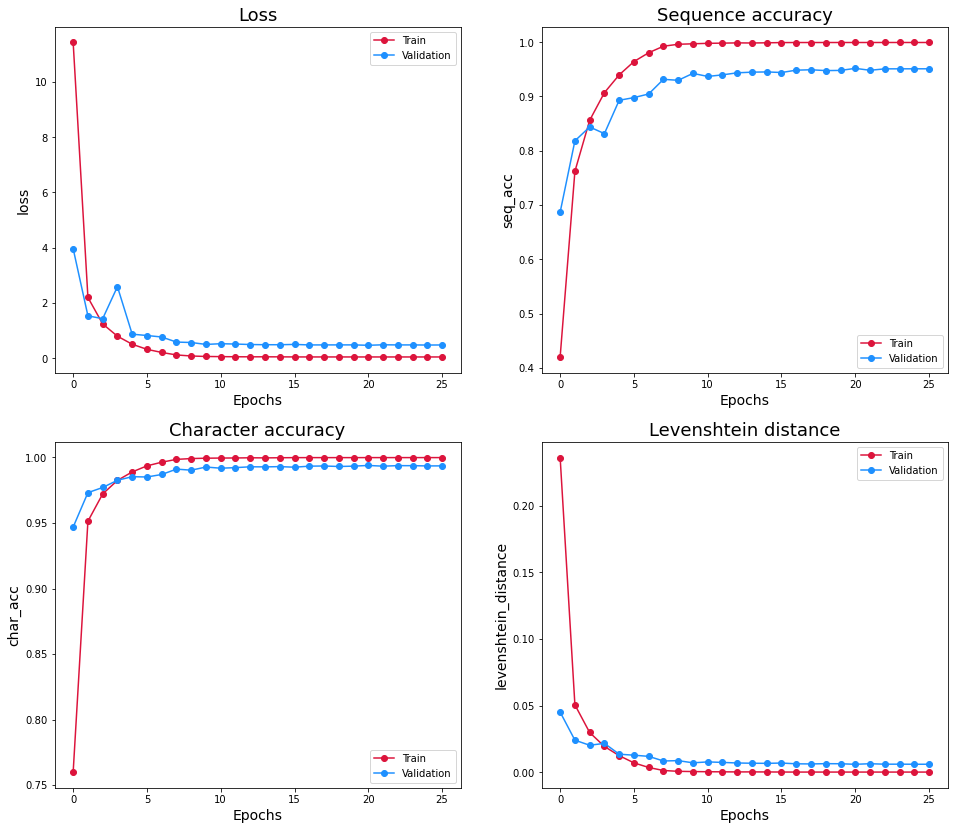

In [18]:
from visualizer import plot_training_results
plot_training_results(history, f'{APPROACH_NAME}.png')
model.save_weights(f'{APPROACH_NAME}.h5')

# Inference

In [16]:
reset_model = build_crnn(imagenet_model, imagenet_output_layer)
reset_model.load_weights(f'{APPROACH_NAME}.h5')
reset_model.summary(line_length=110)

Model: "CRNN"
______________________________________________________________________________________________________________
 Layer (type)                       Output Shape            Param #      Connected to                         
 image (InputLayer)                 [(None, 432, 48, 3)]    0            []                                   
                                                                                                              
 block1_conv1 (Conv2D)              (None, 432, 48, 64)     1792         ['image[0][0]']                      
                                                                                                              
 block1_bn1 (BatchNormalization)    (None, 432, 48, 64)     256          ['block1_conv1[0][0]']               
                                                                                                              
 block1_activation1 (LeakyReLU)     (None, 432, 48, 64)     0            ['block1_bn1[0][0]']     

 rnn_output (Dense)                 (None, 25, 13171)       13500275     ['skip_connection[0][0]']            
                                                                                                              
Total params: 30,610,931
Trainable params: 30,604,403
Non-trainable params: 6,528
______________________________________________________________________________________________________________


In [17]:
reset_model.compile(
    optimizer = Adadelta(LEARNING_RATE), 
    loss = CTCLoss(PADDING_TOKEN), 
    metrics = [
        SequenceAccuracy(PADDING_TOKEN, use_ctc_decode=True),
        CharacterAccuracy(PADDING_TOKEN, use_ctc_decode=True),
        LevenshteinDistance(PADDING_TOKEN, use_ctc_decode=True, normalize=True)
    ]
)
reset_model.evaluate(valid_tf_dataset)

635/635 [==============================] - 53s 79ms/step - loss: 0.4634 - seq_acc: 0.9517 - char_acc: 0.9939 - levenshtein_distance: 0.0059


[0.46341273188591003,
 0.9517408013343811,
 0.9939199686050415,
 0.005933505482971668]

## On test dataset

Batch 01:
- True: {1: '二十日詔自今凣士人', 2: '及春秋髙而理明德', 3: '事其求封辝畧日國人徧', 4: '告立皇太子并賜綵幣', 5: '是皆揭標的於當時', 6: '因以上褚五十衣中褚', 7: '如各衙門應差捕得', 8: '脩政事有所舛紊人', 9: '帝親征何洞等四十九', 10: '下令各依圖次而退', 11: '咍𢶢𦷾渚底咹\U000f12d4𣈜𬧻', 12: '賭博之術不足以施', 13: '不能\U000f0c46\U000f0c47教士卒甚銳', 14: '命朝臣舉縣官聀有', 15: '至是令人排辨香花', 16: '及長容貌環偉聰明過', 17: '六月色旨禮部議定民', 18: '黎志兵部上書定功伯', 19: '冬十月詔傳位於皇太子', 20: '文武臣僚見者流涕', 21: '恩州阮啟使其子來行', 22: '長子昔以正位東宫', 23: '詔諸軍民不得服北人', 24: '上曰爾子幾人乎對', 25: '其村商賣怒廊百公', 26: '故合格黄袍者止八十', 27: '茂洽見有羙色心中悅', 28: '揮使掌衛事兼知豊祜堂', 29: '舍江至安决黔皷山駐營', 30: '後倚蘭夫人有娠生皇子', 31: '為以妾前年又𭁈宮女阮', 32: '號有厲致眾於朋來'}
- Pred: {1: '二十日詔自今凣士人', 2: '及春秋髙而理明德', 3: '事其求封辝畧日國人徧', 4: '告立皇太子并賜綵幣', 5: '是皆揭標的於當時', 6: '因以上褚五十衣中褚', 7: '如各衙門應差捕得', 8: '脩政事有所射紊人', 9: '帝親征何洞等四十九', 10: '下令各依圖次而退', 11: '咍𢶢𦷾渚底咹\U000f12d4𣈜𬧻', 12: '賭博之術不足以施', 13: '不能\U000f0c46\U000f0c47教士卒甚銳', 14: '命朝臣舉縣官聀有', 15: '至是令人排辨香花', 16: '及長容貌環偉聰明過', 17: '六月色旨禮部議定民', 18: '黎志兵部上書定功伯', 19: '冬十月詔傳位於皇太子', 20: '文武臣僚見者流涕', 21: '恩州阮啟使其子來行', 22: '長子昔以正位東宫', 23: '詔諸軍民不得服北人', 24: '上曰爾子幾人乎對', 

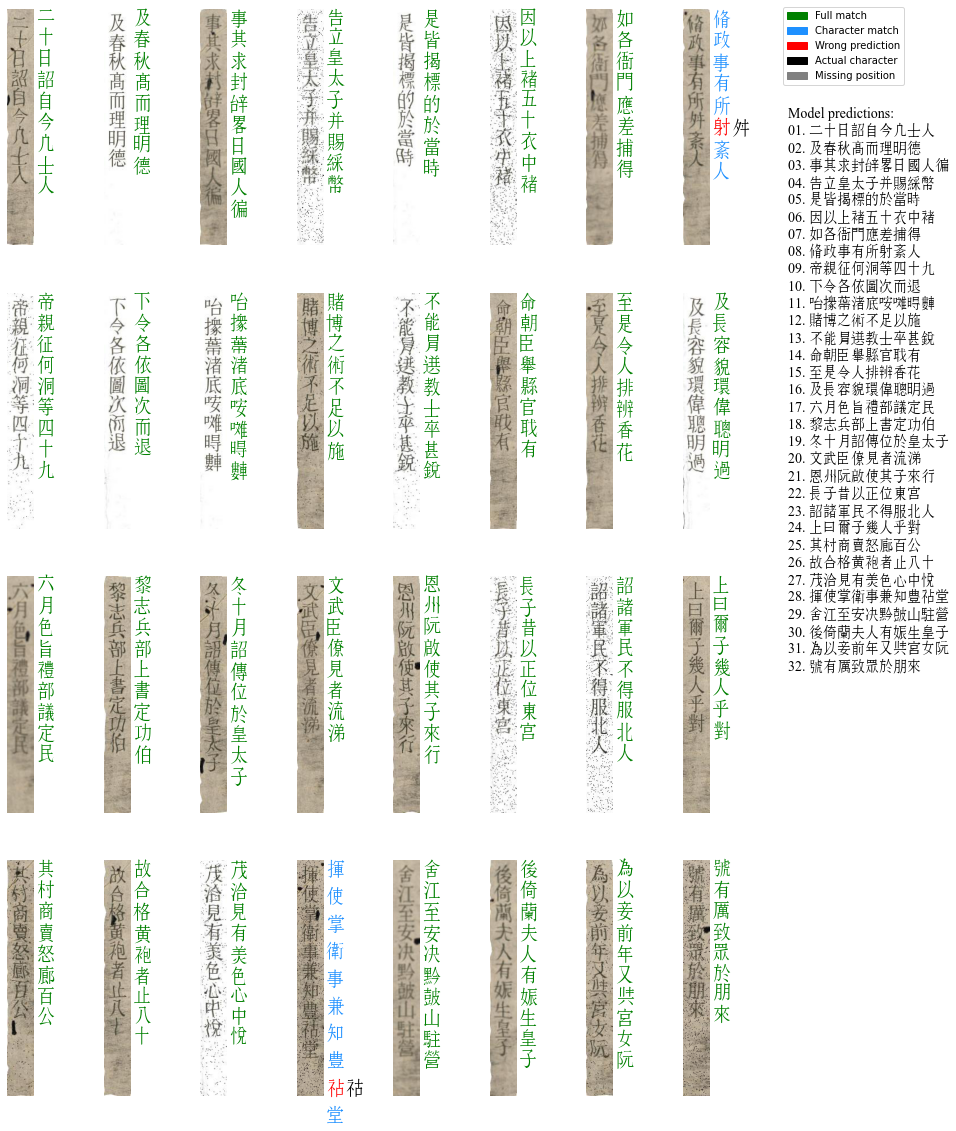

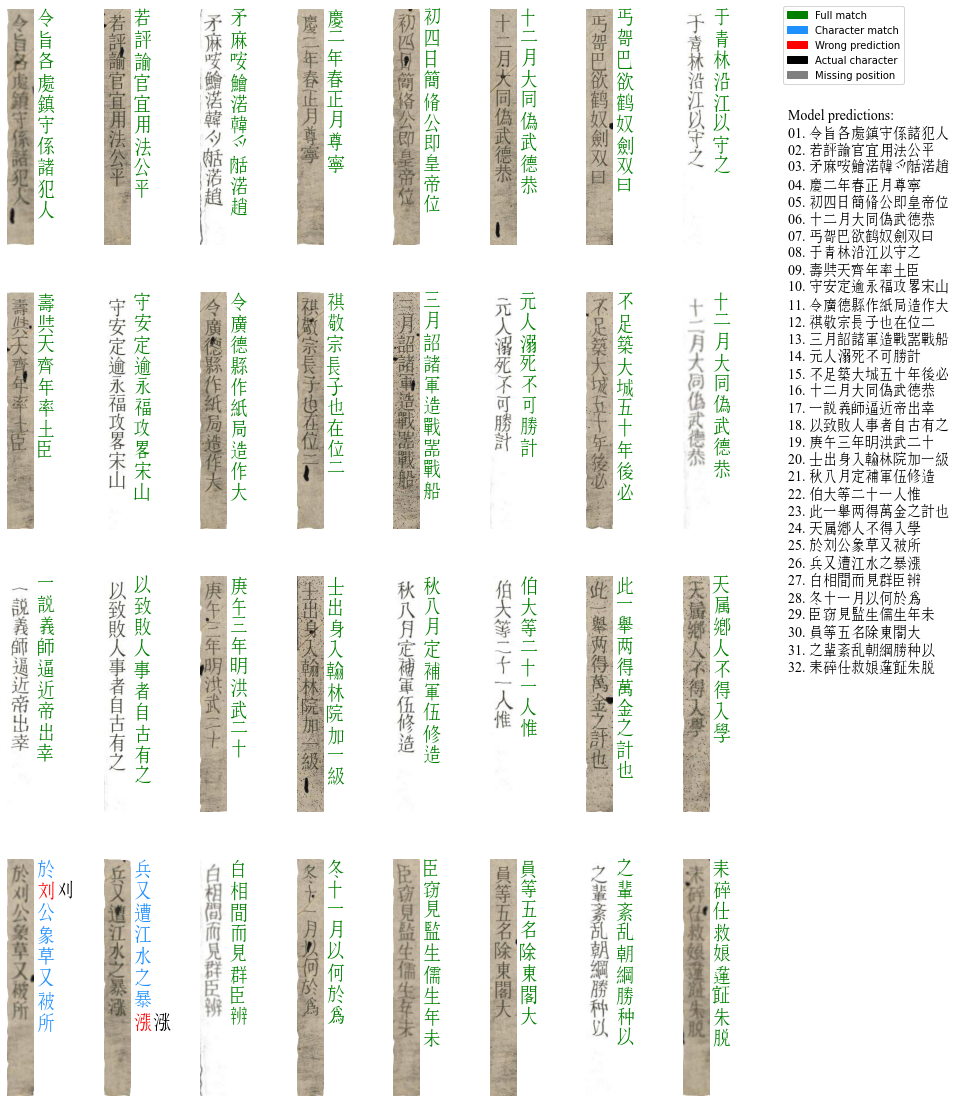

In [18]:
for idx, (batch_images, batch_tokens) in enumerate(valid_tf_dataset.take(2)):
    idxs_in_batch = valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    labels = data_handler.tokens2texts(batch_tokens)
    pred_tokens = reset_model.predict(batch_images)
    pred_labels = data_handler.tokens2texts(pred_tokens, use_ctc_decode=True)
    
    visualize_images_labels(
        img_paths = dataset.img_paths[idxs_in_batch], 
        labels = labels, 
        pred_labels = pred_labels,
        figsize = (14, 20),
        subplot_size = (4, 8),
        legend_loc = (3.8, 4.28),
        annotate_loc = (4, 1.8),
        font_path = FONT_PATH, 
        text_x = WIDTH + 5 # Position of actual label to plot
    )
    print(
        f'Batch {idx + 1:02d}:\n'
        f'- True: {dict(enumerate(labels, start=1))}\n'
        f'- Pred: {dict(enumerate(pred_labels, start=1))}\n'
    )

## On random image

In [19]:
random_path = '../囷𦝄苔惮󰞺𧍋𦬑囊.jpg'
random_label = '囷𦝄苔惮󰞺𧍋𦬑囊'
random_image = data_handler.process_image(random_path)
pred_tokens = reset_model.predict(tf.expand_dims(random_image, axis=0))
pred_labels = data_handler.tokens2texts(pred_tokens, use_ctc_decode=True)

Predicted text: 囷𦝄苔惮󰞺𧍋𦬑囊


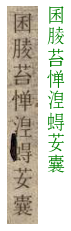

In [20]:
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    font_path = FONT_PATH, 
    text_x = 40 # Position to plot actual label
)
print('Predicted text:', ''.join(pred_labels))